### Complete Modular MLflow Pipeline (Scikit-learn)
| Feature                                          | Purpose                                         |
| ------------------------------------------------ | ----------------------------------------------- |
| `log_params`, `log_metric`                     | Track model settings & performance              |
| `set_tags`                                     | Add metadata for tracking/filtering             |
| `log_model` with `signature` & `input_example` | Enable model reproducibility & validation       |
| `log_artifact`                                 | Save confusion matrix, SHAP plots, and reports  |
| `log_dict`                                     | Save configuration (hyperparameters, settings)  |
| `log_model` with `conda_env`                   | Ensure environment reproducibility              |
| SHAP                                           | Model explainability for audit or visualization |


In [ ]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import shap
import os

In [ ]:

# ---- Step 1: Define your model training and evaluation ----
def model_training_predict(params, X_train, y_train, X_test, y_test, model_class):
    model = model_class(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    return model, y_pred, accuracy

# ---- Step 2: Save evaluation reports and plots ----
def log_evaluation_artifacts(y_test, y_pred):
    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_path = "others/classification_report.csv"
    pd.DataFrame(report).transpose().to_csv(report_path)
    mlflow.log_artifact(report_path)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    report_path = "others/confusion_matrix.png"
    plt.savefig(report_path)
    mlflow.log_artifact(report_path)

# ---- Step 3: Optional - Log SHAP explainability ----
def log_shap_summary_plot(model, X_train, X_test):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)   # three class, sharp_value is 3D array
    
    # For multi-class output, shap_values[i] gives class i
    # Pick one class to visualize, e.g., class 0
    shap_class_0 = shap_values[:, :, 0]
    shap.plots.beeswarm(shap_class_0, show=False)
    report_path = "others/shap_beeswarm_class0.png"
    plt.savefig(report_path)
    mlflow.log_artifact(report_path)

# ---- Step 4: Track everything in MLflow ----
def run_mlflow_pipeline(X_train, y_train, X_test, y_test, model_class, params, model_name="iris_project"):

    with mlflow.start_run():

        # Train and predict
        model, y_pred, accuracy = model_training_predict(params, X_train, y_train, X_test, y_test, model_class)

        # Log params and metrics
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", accuracy)

        # Add metadata
        mlflow.set_tags({
            "project": "iris",
            "author": "Peter Chen",
            "run type": "baseline"
        })

        # Infer signature and log model
        signature = infer_signature(X_train, y_pred)
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="iris_model",
            signature=signature,
            input_example=X_train,
            registered_model_name=model_name
        )

        # Log additional artifacts (optional)
        log_evaluation_artifacts(y_test, y_pred)
        log_shap_summary_plot(model, X_train, X_test)

        # Save params as JSON (optional)
        mlflow.log_dict(params, "training_params.json")    # Save configuration (hyperparameters, settings) in json file

        # Save reproducible environment (optional)
        conda_env = _mlflow_conda_env(additional_pip_deps=["scikit-learn", "mlflow", "shap"])
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="iris_model_with_env",
            conda_env=conda_env
        )

### Run mlflow with iris project

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load data
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=8888)


mlflow.set_tracking_uri(uri='http://127.0.0.1:5000')
mlflow.set_experiment('iris_expt2')

2025/06/11 03:19:37 INFO mlflow.tracking.fluent: Experiment with name 'iris_expt2' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/668754016532033125', creation_time=1749626377425, experiment_id='668754016532033125', last_update_time=1749626377425, lifecycle_stage='active', name='iris_expt2', tags={}>

/home/mchen/miniconda3/envs/mlops/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
2025/06/11 03:19:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'iris_project'.
2025/06/11 03:19:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: iris_project, version 1
Created version '1' of model 'iris_project'.
2025/06/11 03:19:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/11 03:19:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run popular-skink-80 at: http://127.0.0.1:5000/#/experiments/668754016532033125/runs/cdc800620a09438c875d08066d273bf3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/668754016532033125


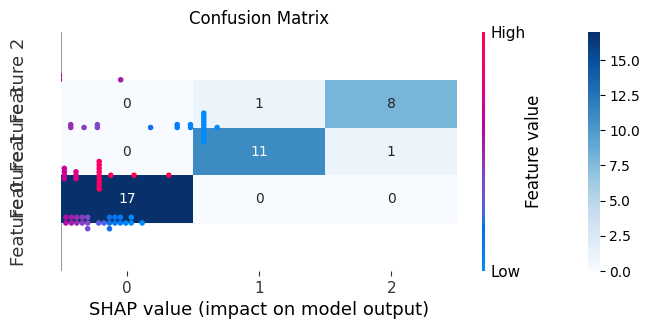

In [4]:
# Run 1

# Define hyperparameters
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 8888
}

# Run the MLflow tracking pipeline
run_mlflow_pipeline(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_class=LogisticRegression,
    params=params,
    model_name="iris_project"
)

/home/mchen/miniconda3/envs/mlops/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
2025/06/11 03:19:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'iris_project' already exists. Creating a new version of this model...
2025/06/11 03:19:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: iris_project, version 2
Created version '2' of model 'iris_project'.
2025/06/11 03:19:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/11 03:19:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer t

🏃 View run loud-auk-26 at: http://127.0.0.1:5000/#/experiments/668754016532033125/runs/8de5a3cf2c424566b177cdf118678a66
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/668754016532033125


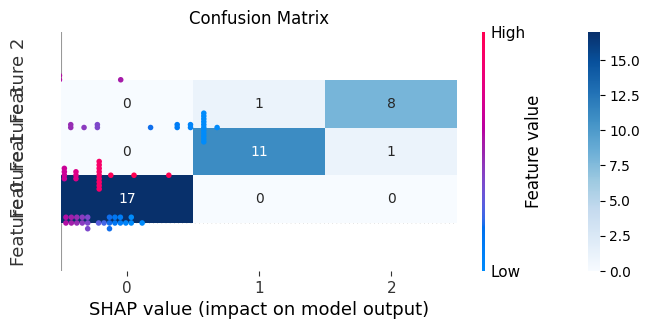

In [5]:
# Run 2: change random_state to 100

# Define hyperparameters
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 100
}

# Run the MLflow tracking pipeline
run_mlflow_pipeline(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_class=LogisticRegression,
    params=params,
    model_name="iris_project"
)

In [ ]:
run_id = '8de5a3cf2c424566b177cdf118678a66'   # replace run_id obtained from mlflow
mlflow.register_model(
    model_uri=f"runs:/{run_id}/iris_model",
    name="iris_project"
)

Registered model 'iris_project' already exists. Creating a new version of this model...
2025/06/11 03:21:06 WARNING mlflow.tracking._model_registry.fluent: Run with id 8de5a3cf2c424566b177cdf118678a66 has no artifacts at artifact path 'iris_model', registering model based on models:/m-f419f2a6bbe342ffb6004e4885e0ffb9 instead
2025/06/11 03:21:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: iris_project, version 3
Created version '3' of model 'iris_project'.


<ModelVersion: aliases=[], creation_timestamp=1749626466485, current_stage='None', deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1749626466485, metrics=None, model_id=None, name='iris_project', params=None, run_id='8de5a3cf2c424566b177cdf118678a66', run_link='', source='models:/m-f419f2a6bbe342ffb6004e4885e0ffb9', status='READY', status_message=None, tags={}, user_id='', version='3'>